In [48]:
from ctapipe.io import event_source
from scipy.linalg import svd
from ctapipe.utils import get_dataset
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
from ctapipe.visualization import CameraDisplay
import hipecta
from ctapipe.image import convert_geometry_hex1d_to_rect2d
from ctapipe.image import convert_geometry_rect2d_back_to_hexe1d
from ctapipe.calib import CameraCalibrator
import copy
from ctapipe.image import tailcuts_clean
import astropy.units as u
from scipy import ndimage

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

%matplotlib inline

In [2]:
def samples_calibration(event, tel_id):
    data = event.r0.tel[tel_id].waveform[0]
    ped = event.mc.tel[tel_id].pedestal[0]
    nsamples = data.shape[1]
    dc2pe = event.mc.tel[tel_id].dc_to_pe[0]
    calibrated_samples = (data - ped[...,None]/nsamples)*dc2pe[...,None]
    return calibrated_samples

In [105]:
def make_square_samples(camera, samples, key=1):
    square_samples = []
    for image in samples:
        square_geom, square = convert_geometry_hex1d_to_rect2d(camera, image, key=key)
        square_samples.append(square)
    return square_geom, square_samples

In [4]:
cal = CameraCalibrator(None, None, r1_product='HESSIOR1Calibrator', extractor_product='NeighbourPeakIntegrator')

In [5]:
filename = '/Users/thomasvuillaume/Work/CTA/Data/Simtel/gamma_20deg_0deg_run100___cta-prod3-lapalma3-2147m-LaPalma.simtel.gz'

source = event_source(filename)
source.max_events = 30

event = next(iter(source))

In [90]:
def tailcut_cleaning(event, tel_id, **tailcut_params):
    camera = event.inst.subarray.tel[tel_id].camera
    image = event.dl1.tel[tel_id].image[0]
    tailcut_cleanmask = tailcuts_clean(camera, image, **tailcut_params)
    
    tailcut_cleaned = copy.copy(event.dl1.tel[tel_id].image[0])
    tailcut_cleaned[~tailcut_cleanmask] = 0
    
    return tailcut_cleaned

In [70]:
tailcut_params = {'picture_thresh':8,
                  'boundary_thresh':3,
                  'keep_isolated_pixels':False,
                  'min_number_picture_neighbors':1,
                 }

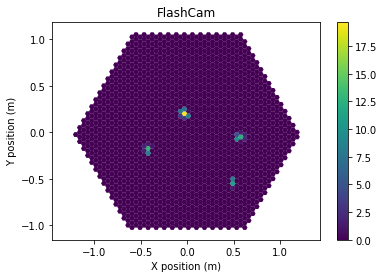

In [81]:
cal.calibrate(event)

tel_id = list(event.r0.tels_with_data)[0]

tailcut_cleaned = tailcut_cleaning(event, tel_id, **tailcut_params)

disp = CameraDisplay(camera, tailcut_cleaned)
disp.add_colorbar()

In [47]:
event.inst.subarray.tel[tel_id].camera.pix_type

'hexagonal'

In [110]:
def cleaning_3d(event, tel_id, **kwargs):
    """
    update kwargs
    """

    # for tel_id in event.r0.tels_with_data:
    
    calibrated_samples = samples_calibration(event, tel_id)
    camera = event.inst.subarray.tel[tel_id].camera    
        
    key = camera.cam_id
    square_geom, square_calibrated_samples = make_square_samples(camera, calibrated_samples.T, key=key)
    square_calibrated_samples = np.nan_to_num(square_calibrated_samples)

    thresh = 0.1
    binary_samples = np.zeros_like(square_calibrated_samples)
    binary_samples[square_calibrated_samples>thresh] = 1
    mask = ndimage.binary_opening(binary_samples, 
                                  iterations=1, 
                                  structure=np.ones((2,2,2), dtype=bool))


    clean_calibrated_samples = np.zeros_like(calibrated_samples)

    for i, m in enumerate(mask):
        clean = copy.deepcopy(square_calibrated_samples[i])
        clean[~m] = 0
        hex_geom, hex_image = convert_geometry_rect2d_back_to_hexe1d(square_geom, 
                                           clean, 
                                           key=key)
        
        clean_calibrated_samples.T[i] = hex_image
        # CameraDisplay(hex_geom, hex_image)
        # plt.show()

    clean_calibrated_image = clean_calibrated_samples.sum(axis=1)
    recleaned = copy.copy(clean_calibrated_image)
    tailcut_cleanmask = tailcuts_clean(camera, recleaned, **tailcut_params)
    recleaned[~tailcut_cleanmask] = 0
    
    return clean_calibrated_image, recleaned

In [100]:
def compute_diff(true, clean):
    return np.linalg.norm(true-clean)

In [121]:
def compare_plot(event, tel_id):
    
    cal.calibrate(event)
    
    clean3d, recleaned = cleaning_3d(event, tel_id)
    tailcut_cleaned = tailcut_cleaning(event, tel_id, **tailcut_params)

    fig, axes = plt.subplots(1, 4, figsize=(15,5))
    camera = event.inst.subarray.tel[tel_id].camera
    true_image = event.mc.tel[tel_id].photo_electron_image
    CameraDisplay(camera, true_image, ax=axes[0])
    axes[0].set_title("true")
    CameraDisplay(camera, tailcut_cleaned, ax=axes[1])
    axes[1].set_title("tailcut")
    CameraDisplay(camera, clean3d, ax=axes[2])
    axes[2].set_title("3d cleaning")
    CameraDisplay(camera, recleaned, ax=axes[3])
    axes[3].set_title("recleaned")
    
    print("Tailcut diff = {}".format(compute_diff(true_image, tailcut_cleaned)))
    print("3d diff = {}".format(compute_diff(true_image, clean3d)))
    print("Recleaned diff = {}".format(compute_diff(true_image, recleaned)))

In [112]:
%pdb

Automatic pdb calling has been turned OFF


Tailcut diff = 60.09581617233731
3d diff = 53.87530956973461
Recleaned diff = 27.358240508992026


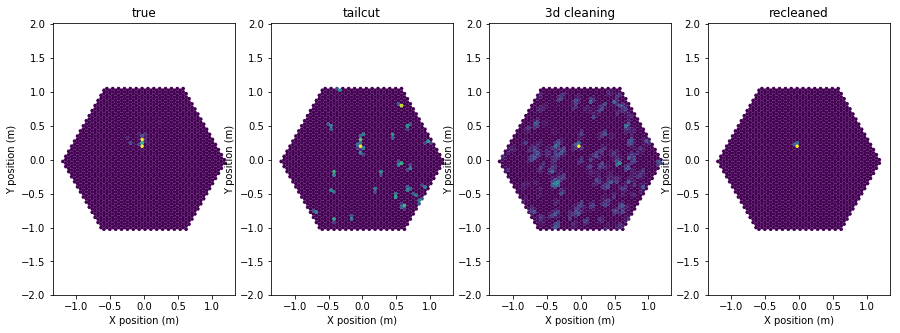

Tailcut diff = 58.7533137784449
3d diff = 55.98924133031405
Recleaned diff = 24.882366787600013


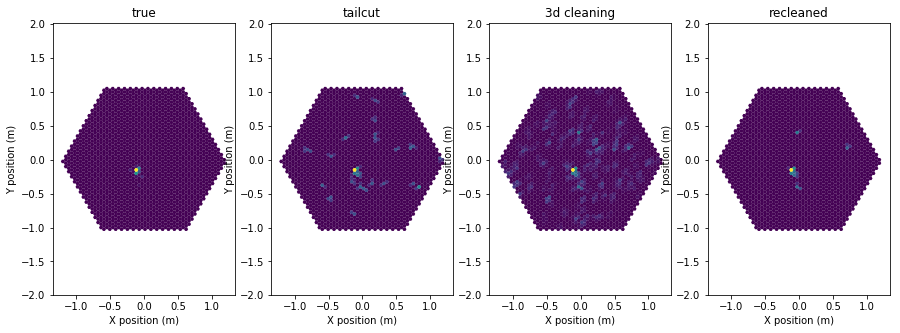

Tailcut diff = 8.993808046562632
3d diff = 33.82517791656061
Recleaned diff = 29.387018924453685


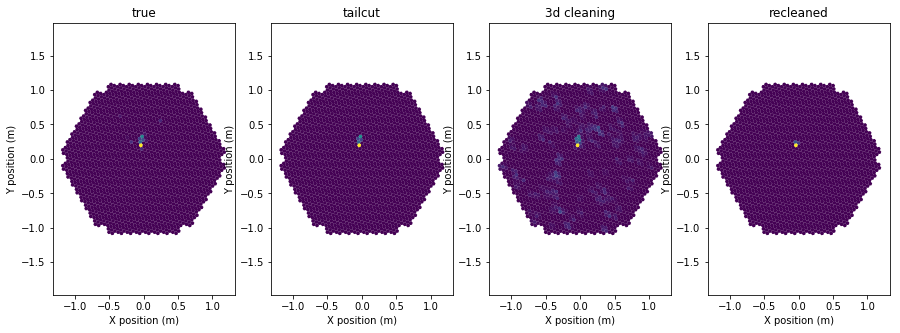

Tailcut diff = 11.345960473315857
3d diff = 45.79303230203587
Recleaned diff = 43.77213725647858


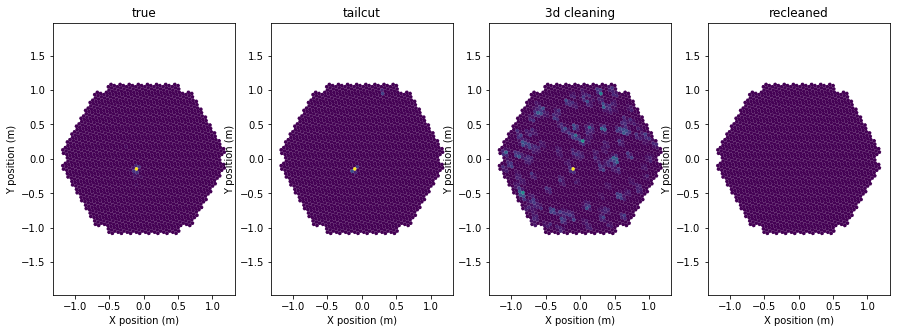

In [122]:
for tel_id in event.r0.tels_with_data:
    compare_plot(event, tel_id)
    plt.show()

## Next
- optimize tailcult
- optimize 3d cleaning
- benchmark